In [2]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import utils as utl
import matplotlib.pyplot as plt
from IPython.display import display

In [5]:
data = pd.read_csv('./data/SSO_UBT_UST_UGL__historical_data.csv')
data.dropna(inplace= True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
data

,SSO,UBT,UST,UGL
Date,,,,
2010-02-02,4.398680,16.248804,31.798576,45.980000
2010-02-03,4.356284,15.873259,31.498878,45.560001
2010-02-04,4.090127,16.373993,31.990908,41.970001
2010-02-05,4.111325,16.435446,32.201134,42.139999
2010-02-08,4.045373,16.505997,32.138523,41.709999
...,...,...,...,...
2022-02-28,61.320000,48.660000,64.540001,64.709999
2022-03-01,59.459999,49.889999,65.730003,67.180000
2022-03-02,61.599998,46.410000,64.150002,65.760002


In [261]:
#qs.plots.snapshot(data['SSO'], title='SSO Performance')
#qs.plots.snapshot(data['UBT'], title='UBT Performance')
#qs.plots.snapshot(data['UST'], title='UST Performance')
#qs.plots.snapshot(data['UGL'], title='UGL Performance')

In [6]:
data_r = data.div(data.shift(1))-1
data_r.dropna(inplace = True)
data_r.describe().T

,count,mean,std,min,25%,50%,75%,max
SSO,3043.0,0.001088,0.021547,-0.233582,-0.006890,0.001429,0.010847,0.188928
UBT,3043.0,0.000528,0.018140,-0.156310,-0.010237,0.001086,0.011247,0.130046
UST,3043.0,0.000267,0.007459,-0.036097,-0.004241,0.000370,0.004632,0.041853
UGL,3043.0,0.000330,0.019909,-0.176118,-0.009729,0.000647,0.010577,0.118644


          SSO       UBT       UST       UGL
SSO  1.000000 -0.462765 -0.422462  0.019036
UBT -0.462765  1.000000  0.892533  0.221997
UST -0.422462  0.892533  1.000000  0.277376
UGL  0.019036  0.221997  0.277376  1.000000


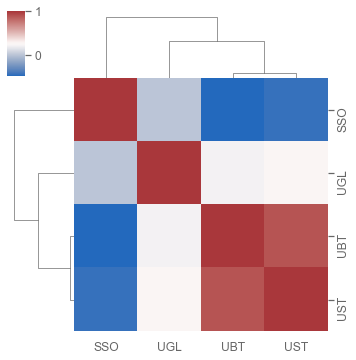

In [7]:
corr = data_r.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')

In [8]:
display(utl.describe_sr(data_r))

,SSO,UBT,UST,UGL
Return,0.273927,0.133079,0.067255,0.083017
Volatility,0.341929,0.287871,0.118369,0.315939
Sharpe,0.801122,0.462288,0.568180,0.262763
Skew,-0.576743,-0.059114,-0.044607,-0.417588
Kurt,14.627140,4.716307,1.828647,5.137386
Max DD,-0.593411,-0.425227,-0.200610,-0.759253
mean,0.001088,0.000528,0.000267,0.000330
std,0.021547,0.018140,0.007459,0.019909
min,-0.233582,-0.156310,-0.036097,-0.176118
25%,-0.006890,-0.010237,-0.004241,-0.009729


In [9]:
def df_inverse_volatility(df_perc, window):
    
    #compute the  1/ volatility (standard_deviation) over a range of window days
    return df_perc.rolling(window).apply(lambda x: 1/(x.std()))

In [10]:
inv_volat_df =  df_inverse_volatility(data_r, 30)
inv_volat_df.dropna(inplace= True)

In [11]:
def df_wheighted(inv_volat_df):
    
    #create a new df with the same columns
    df = pd.DataFrame(columns = inv_volat_df.columns)
    
    #itarate over row (always avoid it, if possible) 
    for index, row in inv_volat_df.iterrows():
        
        #append the new value at each row
        df.loc[index] = row.div(sum(list(row)))
    return df

In [12]:
df_weight_portf = df_wheighted(inv_volat_df)
df_weight_portf

,SSO,UBT,UST,UGL
2010-03-17,0.183238,0.226305,0.456878,0.133580
2010-03-18,0.179698,0.230219,0.460692,0.129391
2010-03-19,0.216616,0.219793,0.429674,0.133916
2010-03-22,0.214920,0.218744,0.434270,0.132066
2010-03-23,0.224428,0.214696,0.429729,0.131147
...,...,...,...,...
2022-02-28,0.144642,0.196235,0.411212,0.247911
2022-03-01,0.147400,0.204751,0.408228,0.239621
2022-03-02,0.152573,0.185573,0.418652,0.243203
2022-03-03,0.151794,0.181665,0.415980,0.250560


In [13]:
def df_earnings(df_weight_portf, data_r):
    
    #compte the earning dataframe (df_weight*df_percentage - entries by entries)
    return df_weight_portf*data_r

In [14]:
df_return = df_earnings(df_weight_portf, data_r)
df_return.dropna(inplace = True)
df_return['Tot'] = df_return.sum(axis=1)
df_return 

,SSO,UBT,UST,UGL,Tot
2010-03-17,0.002168,0.001907,0.001081,-0.001976,0.003180
2010-03-18,-0.000172,-0.001635,0.000000,0.001858,0.000051
2010-03-19,-0.002173,0.000894,-0.002625,-0.004883,-0.008787
2010-03-22,0.002178,0.000428,0.001153,-0.001499,0.002259
2010-03-23,0.003270,-0.002035,-0.000539,0.001240,0.001936
...,...,...,...,...,...
2022-02-28,-0.000728,0.008061,0.008586,0.005003,0.020922
2022-03-01,-0.004471,0.005176,0.007527,0.009146,0.017378
2022-03-02,0.005491,-0.012944,-0.010063,-0.005141,-0.022657
2022-03-03,-0.001429,0.004032,0.001427,0.003124,0.007154


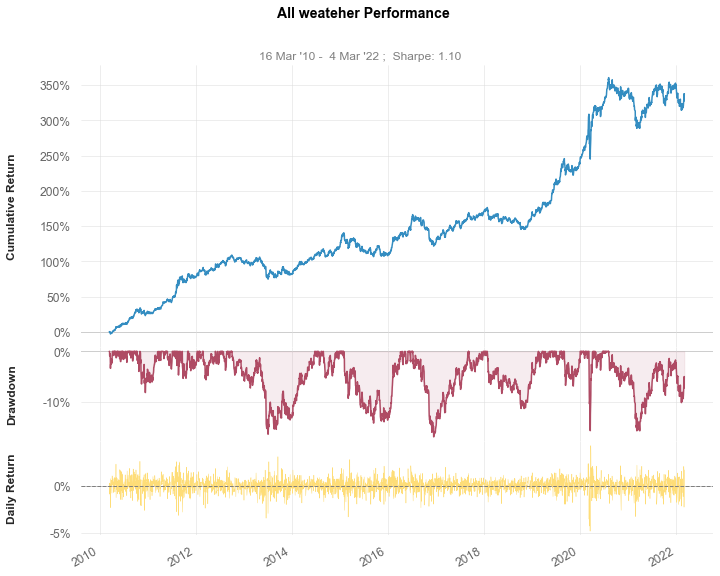

In [13]:
qs.plots.snapshot(df_return['Tot'], title='All weateher Performance')

                           Strategy
-------------------------  ----------
Start Period               2010-03-17
End Period                 2022-03-04
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          337.85%
CAGR﹪                     13.13%

Sharpe                     1.1
Smart Sharpe               1.07
Sortino                    1.59
Smart Sortino              1.54
Sortino/√2                 1.12
Smart Sortino/√2           1.09
Omega                      1.21

Max Drawdown               -16.79%
Longest DD Days            629
Volatility (ann.)          11.81%
Calmar                     0.78
Skew                       -0.29
Kurtosis                   3.01

Expected Daily %           0.05%
Expected Monthly %         1.02%
Expected Yearly %          12.03%
Kelly Criterion            9.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.17%
Expected Shortfall (cVaR)  -1.17%

Gain/Pain Ratio            0.21
Gain/Pain (1M)            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-07-11,2016-12-15,2017-09-05,421,-16.793818,-16.161798
2,2012-10-04,2013-07-05,2014-06-25,629,-16.279336,-15.067529
3,2020-08-07,2021-03-30,2022-03-04,574,-15.608725,-15.223747
4,2020-03-10,2020-03-19,2020-04-09,30,-15.574917,-15.192254
5,2015-02-02,2015-09-15,2016-04-19,442,-14.089956,-13.597506


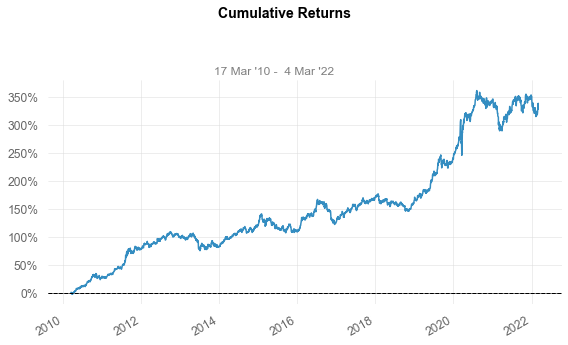

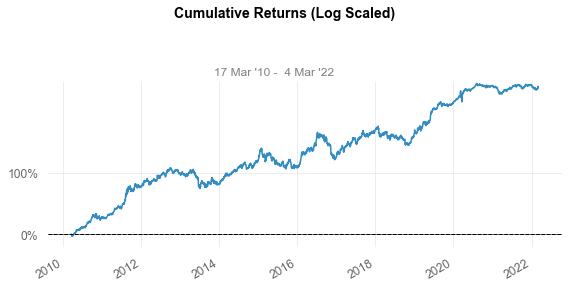

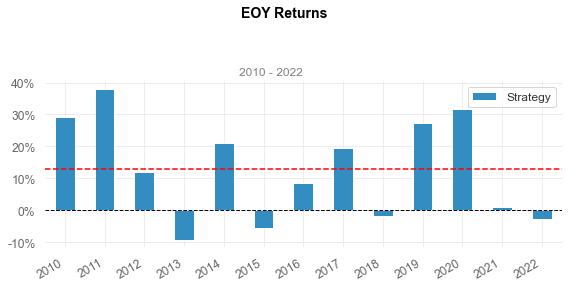

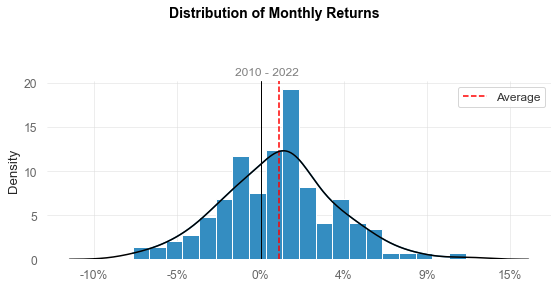

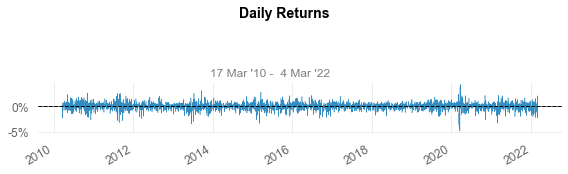

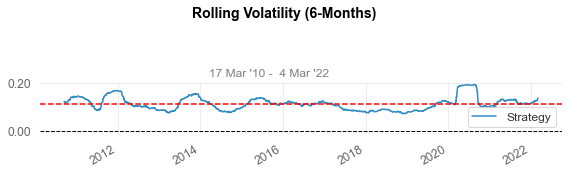

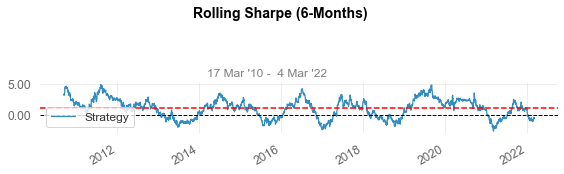

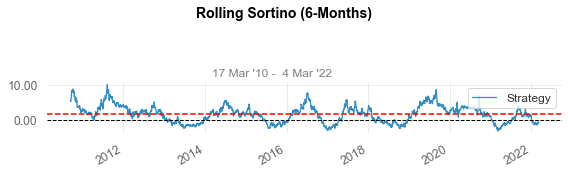

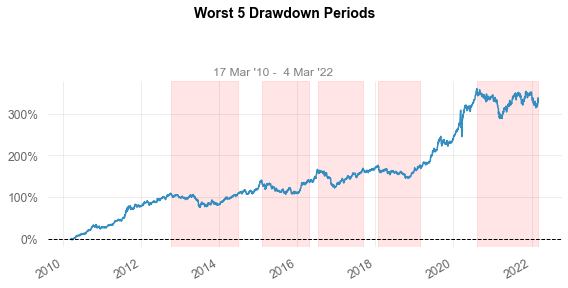

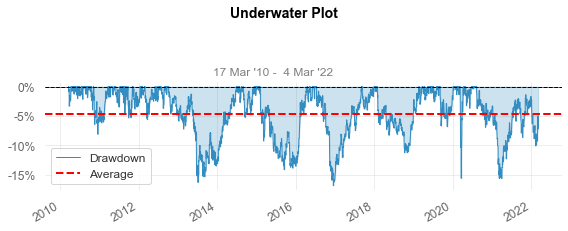

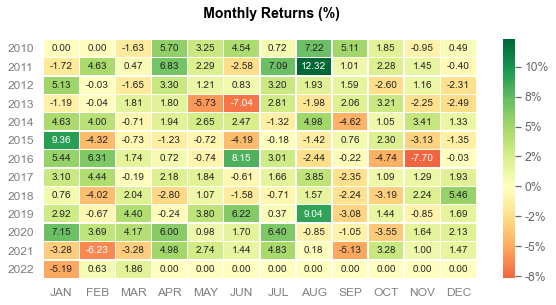

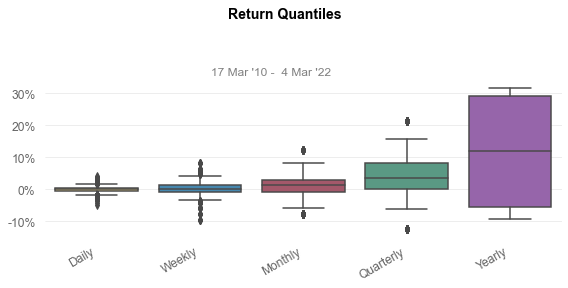

In [13]:
qs.reports.full(df_return['Tot'])

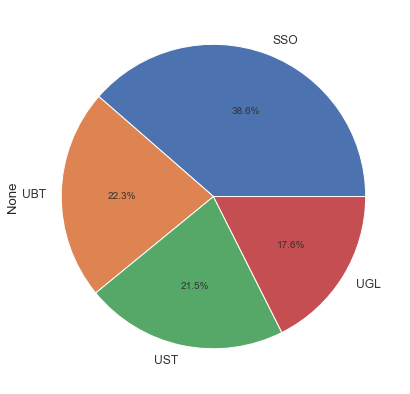

In [16]:
#plot of the average composition of the portfoglio
plot = df_return.drop('Tot', axis=1).sum(axis=0).plot.pie(figsize=(7, 7),autopct='%1.1f%%')

In [15]:
def compute_number_of_securities(df_weight_portf, investment, data):
    
    #multiply the wheighted df for teh invretment tosee how capita there are for each security
    df = df_weight_portf.mul(investment)
    
    #divide by the close price of the day to get the number of securities I can buy
    df = df / data
    
    #convert to integer -> issue: some money are not spent!!
    df = df.dropna().astype(int)
    return df

In [16]:
compute_number_of_securities(df_weight_portf, 10000, data)

,SSO,UBT,UST,UGL
2010-03-17,371,138,141,29
2010-03-18,364,141,143,27
2010-03-19,443,134,134,29
2010-03-22,435,133,135,29
2010-03-23,448,132,134,29
...,...,...,...,...
2022-02-28,23,40,63,38
2022-03-01,24,41,62,35
2022-03-02,24,39,65,36
2022-03-03,24,38,64,37
